In [1]:
import datetime
from itertools import chain, combinations
from time import perf_counter
from itertools import zip_longest
import pathlib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow as pa
import numpy as np
from utils import get_connection, get_crime_codes, get_crime_data

In [2]:
root_dir = pathlib.Path("../data/crime")
with get_connection() as conn:
    try:
        general_df = pd.read_parquet(root_dir/"keys/general_key.parquet")
        specific_df = pd.read_parquet(root_dir/"keys/specific_key.parquet")
        housing_df = pd.read_parquet(root_dir/"keys/housing_key.parquet")
    except FileNotFoundError:
        general_df, specific_df, housing_df = get_crime_codes(conn)
        general_df.to_parquet(root_dir/"keys/general_key.parquet")
        specific_df.to_parquet(root_dir/"keys/specific_key.parquet")
        housing_df.to_parquet(root_dir/"keys/housing_key.parquet")

    try:
        crime_df = pd.read_parquet(root_dir/"precincts")
        if len(crime_df) == 0:
            raise FileNotFoundError
    except FileNotFoundError:
        crime_df = get_crime_data(conn, 2018, 2_000_000, 0)
        crime_df.to_parquet(root_dir/"precincts", partition_cols=['precinct'])

In [3]:
crime_df.describe()

,idx,crime_date,crime_time,crime_close_time,report_date,latitude,longitude,general_code,specific_code,attempted,...,park_name,housing_code,suspect_age,suspect_race,suspect_sex,victim_age,victim_race,victim_sex,crime_close_date,precinct
count,464138,464138,464138,464138,464138,464138,464138,464138,463843,464138,...,464138,464138,464138,464138,464138,464138,464138,464138,398818,464138
unique,464138,1975,1440,1441,365,64798,65298,65,355,2,...,629,350,28,8,4,44,7,5,1309,77
top,188582344,2018-01-01T00:00:00.000,12:00:00,(null),2018-07-05T00:00:00.000,40.750423,-73.98928,341,638,COMPLETED,...,(null),(null),UNKNOWN,BLACK,M,25-44,UNKNOWN,F,2018-07-05T00:00:00.000,75
freq,1,1955,12820,65069,1624,1258,1269,86364,51551,456368,...,460125,430417,126261,130996,211206,160906,140590,184711,1349,14790


In [12]:
crime_df['crime_degree'].unique()

array(['FELONY', 'MISDEMEANOR', 'VIOLATION'], dtype=object)

<Axes: xlabel='report_date'>

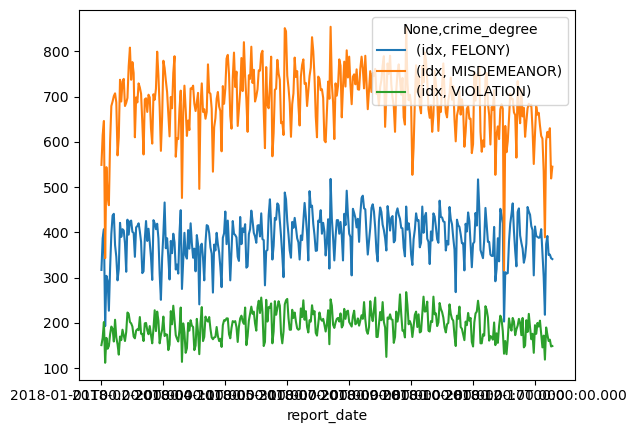

In [15]:
crime_df[['report_date', 'idx', 'crime_degree']].groupby(['crime_degree','report_date']).count().unstack('crime_degree').plot()